In [119]:
import json

output_files = ['out/out-adam.json',
                'out/out-sgd-momentum.json',
                'out/out-sgd-vanilla.json']

# Load data
data = []
for output_file in output_files:
    with open(output_file, mode='r', encoding='utf-8') as f:
        data += json.load(f)


def get_model_results(model_name):
    for d in data:
        if d['model'].lower() == model_name.lower():
            yield d



In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_model_results(model_results):
    fig = plt.figure(model_name)
    
    prod = itertools.product(('train', 'test'), ('acc', 'loss'))
    for i, (train_test, acc_loss) in enumerate(prod):
        ax = fig.add_subplot(2, 2, i+1)
        plot_single_case(ax, train_test, acc_loss, model_results)
    
    fig.set_size_inches(9, 6, forward=True)
    fig.suptitle(model_name)
    fig.tight_layout(pad=2)
    
    return fig
    
    
def plot_single_case(ax, train_test, acc_loss, model_results):
    data_type = f'{train_test}_{acc_loss}'
    for curr_result in model_results:
        optimizer_name = curr_result['optimizer']['name']
        optimizer_params = curr_result['optimizer']['params']
        
        if optimizer_name == 'SGD':
            optimizer_label = f"SGD(lr={optimizer_params['lr']}, " \
                              f"mtm={optimizer_params['momentum']})"
        else:
            optimizer_label = f"{optimizer_name}(lr={optimizer_params['lr']})"
        
        data = np.array(curr_result[data_type])
        epochs = data[:, 0]
        values = data[:, 1]
        
        ax.plot(epochs, values, label=optimizer_label)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(f"{train_test} {acc_loss}")
        ax.legend()
        ax.grid()


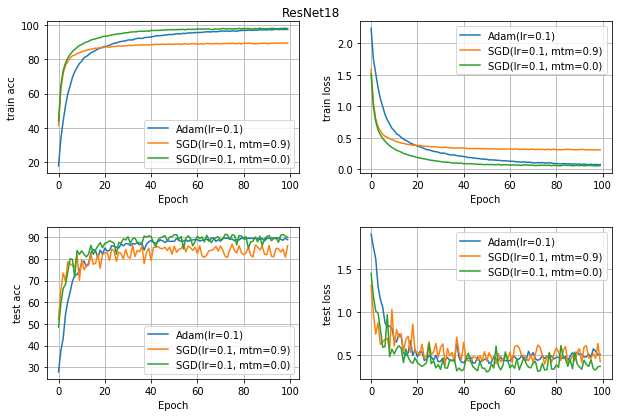

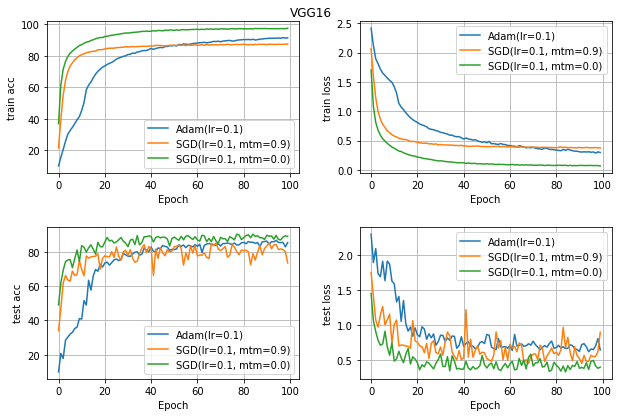

In [118]:
model_names = ['ResNet18', 'VGG16']

for model_name in model_names:
    model_results = [x for x in get_model_results(model_name)]
    fig = plot_model_results(model_results)
    fig.savefig(f"out/{model_name}.pdf")
